# 손실 곡선

Keras에서는 fit() 메서드로 모델을 훈련하면 


**<center> 
    <tensorflow.python.keras.callbacks.History at 0x1e1a2003970> 
    <center>**
    
    

이런 메시지가 같이 출력된다.

이 메시지는 fit()메서드의 실행 결과를 출력한 것이며 **케라스의 fit()메서드는 History 클래스 객체를 반환한다는 것**을 알 수 있었다.

History 객체에는 훈련 과정에서 계산한 지표, 즉 손실과 정확도 값이 저장되어 있어 손실 곡선 그래프를 그리는데 도움을 준다.

다시 모델을 요약해보자.(이전과 같이 패션 mnist 데이터셋을 활용하여 train,valid셋을 만들었다.)

## 1. data 불러오기

In [1]:
from tensorflow import keras
from sklearn.model_selection import train_test_split
(train_input, train_target),(test_input, test_target) = keras.datasets.fashion_mnist.load_data()

train_scaled = train_input/255.0
train_scaled,val_scaled, train_target,val_target = train_test_split(train_scaled, train_target, test_size = 0.2, random_state = 42)

## 2. model 구축 

In [2]:
def model1(a_layer = None) :
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape = (28,28)))
    model.add(keras.layers.Dense(100, activation = 'relu'))
    
    if a_layer :
        model.add(a_layer)
    model.add(keras.layers.Dense(10,activation = 'softmax'))
    return model

모델을 만들때 model1 함수에 a_layer로 층을 추가하면 앞으로 은닉층 뒤에 하나의 층이 추가가 가능하도록 만들었다.

In [3]:
# 모델 요약
model = model1()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               78500     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1010      
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


In [4]:
# 모델 훈련, 이때 fit한 결과를 history에 저장, verbose = 0 으로 훈련과정은 빼버림.
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = 'accuracy')
history = model.fit(train_scaled, train_target, epochs = 5, verbose = 0)

In [5]:
history.history

{'loss': [0.5258648991584778,
  0.3953034579753876,
  0.3523819148540497,
  0.3243083357810974,
  0.305660218000412],
 'accuracy': [0.8165416717529297,
  0.8569791913032532,
  0.8725625276565552,
  0.8812708258628845,
  0.8881250023841858]}

epochs = 5에 따른 **손실과 정확도**가 history에 담겨있는 것을 확인할 수 있다.

### 3. 에포크에 따른 손실 plot


#### accuracy가 아닌 loss를 plot으로 확인하는 이유?

- 인공신경망에서는 모델이 최적화하는 대상이 정확도가 아닌 손실 함수이다. 따라서 모델이 잘 훈련되었는지 확인하려면 정확도보다는 손실 함수의 값을 확인하는 것이 더 좋다.

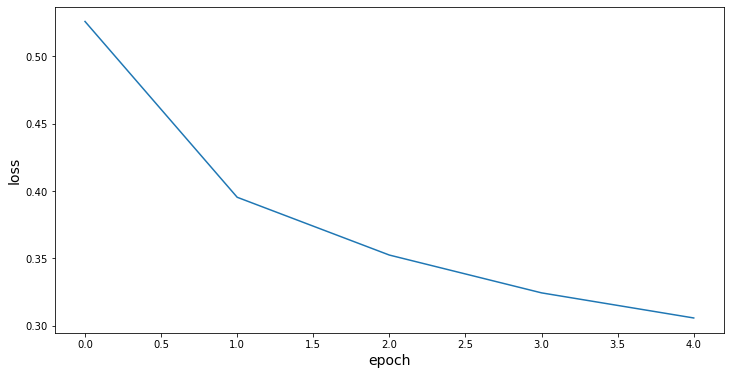

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize = (12,6))
plt.plot(history.history['loss'])
plt.xlabel('epoch', fontsize = 14)
plt.ylabel('loss', fontsize = 14)
plt.show()

**train data**의 에포크별 손실을 그래프로 나타내본 결과, **에포크가 증가할수록 손실이 감소**하는 경향을 보인다. 

따라서 에포크 횟수를 좀 더 증가시켜봤다.

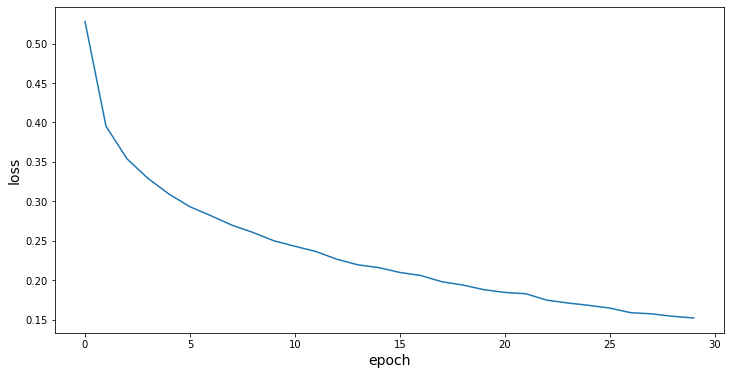

In [7]:
model = model1()
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = 'accuracy')
history = model.fit(train_scaled,train_target, epochs = 30, verbose = 0)
plt.figure(figsize = (12,6))
plt.plot(history.history['loss'])
plt.xlabel('epoch', fontsize = 14)
plt.ylabel('loss', fontsize = 14)
plt.show()

마찬가지로 손실이 잘 감소한다.

train data의 손실 그래프를 그릴 수 있는 것처럼 마찬가지로 valid data에 대한 plot을 그릴 수 있다.

그냥 훈련시킬 때 validation_data()에 valid 데이터를 추가해주면 된다.

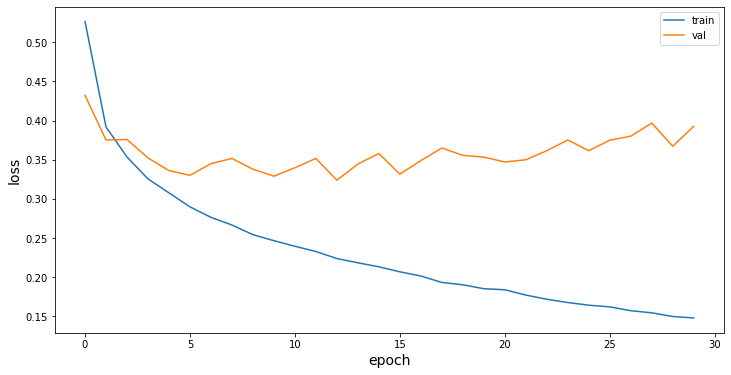

In [8]:
model = model1()
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = 'accuracy')
history = model.fit(train_scaled,train_target, epochs = 30, verbose = 0, validation_data = (val_scaled,val_target))
plt.figure(figsize = (12,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch', fontsize = 14)
plt.ylabel('loss', fontsize = 14)
plt.legend(['train','val'])
plt.show()

train 데이터는 꾸준히 loss가 감소하는 것과 달리 valid 데이터는 loss가 감소하다 말았다.

전형적인 **과대적합** 모델이 만들어졌다. optimizer를 adam에서 기본값으로 바꿔보자.

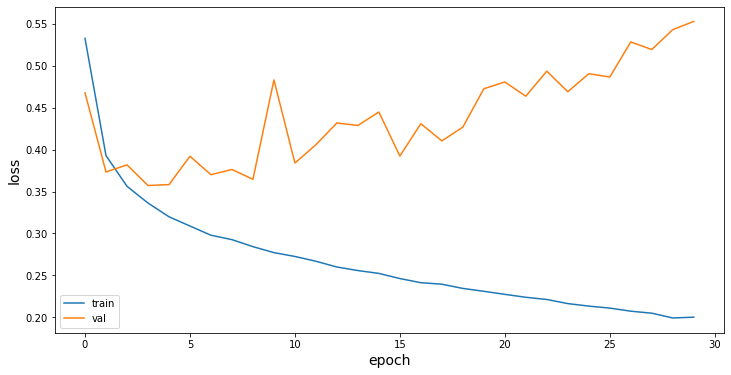

In [9]:
model = model1()
model.compile(loss = 'sparse_categorical_crossentropy', metrics = 'accuracy')
history = model.fit(train_scaled,train_target, epochs = 30, verbose = 0, validation_data = (val_scaled,val_target))
plt.figure(figsize = (12,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch', fontsize = 14)
plt.ylabel('loss', fontsize = 14)
plt.legend(['train','val'])
plt.show()

기본 옵티마이저인 RMSprop로 바꿔보니 adam보다 더 나빠진 상황임을 확인할 수 있다.

adam이 아무래도 RMSpop와 달리 **적응적 학습률을 사용하기 때문에** 에포크에 따라 학습률을 조정해 줬을 것이다. 

## 4. Dropout

- 훈련 과정에서 층에 있는 일부 뉴런(노드)을 랜덤하게 0으로 만들어 과대적합을 방지한다.
![screensh](./images/드롭아웃_전후_예시.png)


### 동작
***
1. 확률 p를 기준으로 입력층과 은닉층의 임의 뉴런을 선택 및 제거<br><br>

2. 임의 노드 제거 상태에서 학습을 수행<br><br>

3. 실제 테스트 시 제거 노드 복원 및 가중치 수행(가중치에 확률 p를 곱하여 결과 보상)
***

### 왜 Dropout이 과대적합을 방지하는가?

- **Co-adaptation 회피** : 이전 층의 일부 뉴런이 랜덤하게 꺼지면 특정 뉴런에 과대하게 의존하는 것을 줄일 수 있고 모든 입력에 주의를 기울이게 된다.(강건한 모델 구축 용이)


- 여러 모델을 종합적으로 고려해서 최적 값을 찾아내는 **앙상블(emsemble)**과 유사하다. 서로 다른 상황을 대입해 문제를 풀고 이해...<br> 즉 서로 다른 모델을 학습 시킨다고 볼 수 있다.

앞서만든 모델에 dropout 층을 추가했다. 케라스에서는 새로운 층에 Dropout 비율만 추가해주면 된다.

In [10]:
model = model1(keras.layers.Dropout(0.3))
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 100)               78500     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 10)                1010      
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


앞선 dropout의 과정에서 본 것처럼 모델을 평가, 예측할 때는 자동으로 dropout을 적용하지 않는다. 


바로 loss plot을 그려본다.

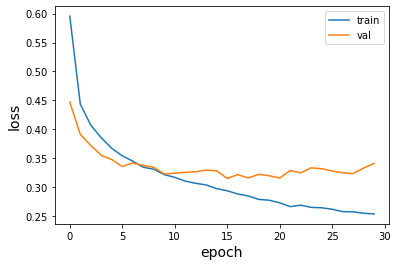

In [11]:
model.compile(optimizer = 'adam',loss = 'sparse_categorical_crossentropy', metrics = 'accuracy')
history = model.fit(train_scaled,train_target, epochs = 30, verbose = 0, validation_data = (val_scaled,val_target))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch', fontsize = 14)
plt.ylabel('loss', fontsize = 14)
plt.legend(['train','val'])
plt.show()

이전보다 valid의 loss가 눈에 띄게 줄어들었다.

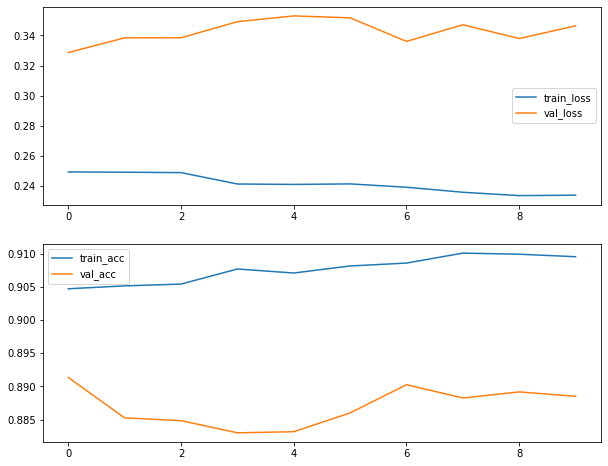

In [12]:
model.compile(optimizer = 'adam',loss = 'sparse_categorical_crossentropy', metrics = 'accuracy')
history = model.fit(train_scaled,train_target, epochs = 10, verbose = 0, validation_data = (val_scaled,val_target))
fig, axs = plt.subplots(2,1, figsize = (10,8))
axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[1].plot(history.history['accuracy'])
axs[1].plot(history.history['val_accuracy'])
axs[0].legend(['train_loss','val_loss'])
axs[1].legend(['train_acc','val_acc'])
plt.show()

accuracy가 가장 높고 loss가 더이상 줄어들지 않는 epoch를 7로 지정한다.

## 5. 모델 예측

사이킷런과 달리 케라스에서는 샘플마다 10개의 클래스에 대한 확률을 반환한다.

In [13]:
predictions = model.predict(val_scaled)
print(predictions[0])

[2.9161991e-20 1.4471594e-25 9.7924781e-29 2.5756346e-23 1.4216222e-19
 5.9898152e-06 2.4424626e-23 2.7955939e-13 9.9999404e-01 1.7872696e-17]


In [14]:
print(val_scaled.shape,predictions.shape)

(12000, 28, 28) (12000, 10)


12000개의 샘플들의 10개의 클래스에 대한 확률을 반환한다.

In [15]:
import numpy as np

val_labels = np.argmax(model.predict(val_scaled), axis = -1)
print(np.mean(val_labels == val_target))

0.8885


예측한 타겟의 값과 기존이 valid 타겟 값을 비교하여 평균을 계산했다.

In [16]:
model.evaluate(val_scaled,val_target)

375/375 [==============================] - 0s 929us/step - loss: 0.3463 - accuracy: 0.8885


[0.3463308811187744, 0.8884999752044678]

모델의 검증셋과 평균을 계산한 정확도가 동일하게 나왔다.

## 6. 예측 결과

타깃 레이블 값
<br>
0 : T-shirt/top <br>
1 : Trouser <br>
2 : Pullover <br>
3 : Dress <br>
4 : Coat <br>
5 : Sandal <br>
6 : Shirt <br>
7 : Sneaker <br>
8 : Bag <br>
9 : Ankel boot

<AxesSubplot:>

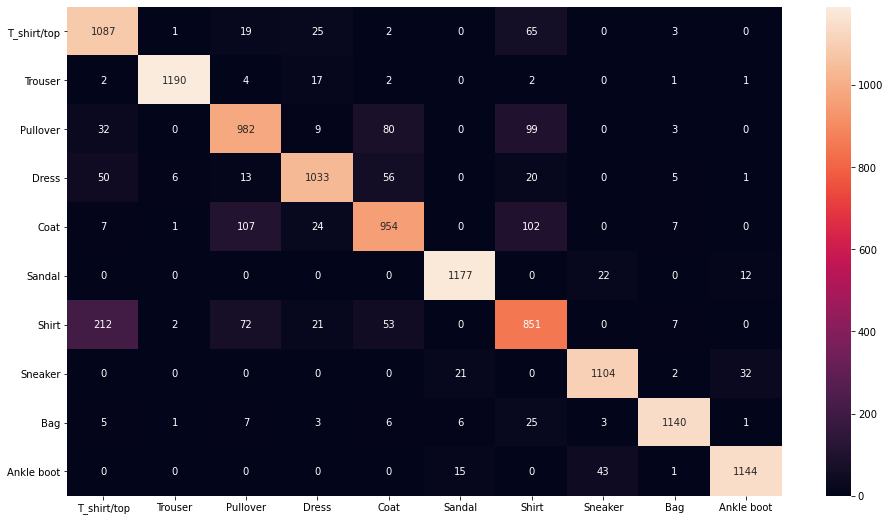

In [17]:
# heatmap으로 예측 결과 확인
from sklearn.metrics import confusion_matrix
import seaborn as sns

class_names = ['T_shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

plt.figure(figsize = (16,9))

cm = confusion_matrix(val_target,val_labels)

sns.heatmap(cm , annot = True,fmt = 'd',xticklabels = class_names,yticklabels = class_names)

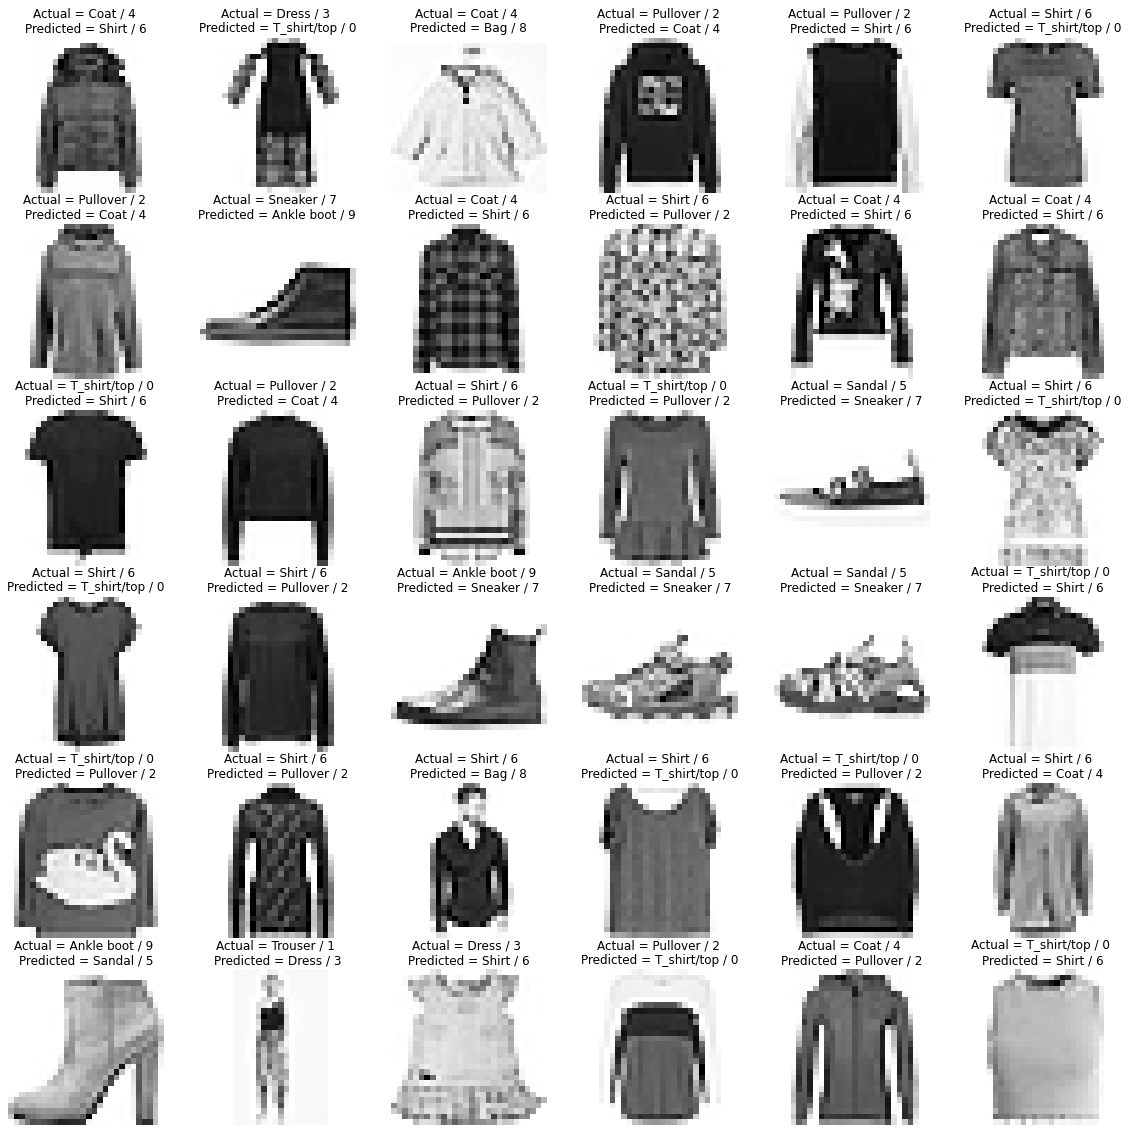

In [18]:
# 이미지로 틀린거 확인하기
# 예측이 맞은 것과 틀린 것 구분하고
aaa = np.array(val_target) != np.array(val_labels)
not_equal_list = np.where(aaa == True)[0]

# 틀린 것들 이미지로 표현하기
plt.figure(figsize = (20,20))
j = 1
# 틀린 것중 36개만 추출
for i in not_equal_list[0:36] :
    plt.subplot(6,6,j);j+=1
    plt.imshow(val_scaled[i].reshape(28,28), cmap = 'Greys')
    plt.axis('off')
    plt.title('Actual = {} / {} \nPredicted = {} / {}'.format(class_names[val_target[i]],
                                                            val_target[i],
                                                            class_names[val_labels[i]],
                                                            val_labels[i]))